# Focus su dataviz applicata al calcio
In questa lezione entreremo più in dettaglio sui metodi più comuni di visualizzazione dei dati in ambito football analytics, in particolare vedremo:

* Scatterplot
* Grafici a barre
* Pizza charts
* Pitch plots: shotmaps, passmaps, heatmaps
Come sempre, iniziamo importando le librerie necessarie. In questo caso, installiamo anche la libreria esterna MplSoccer.

In [2]:
#importazione librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, interpolate
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mplsoccer.pitch import Pitch, VerticalPitch
from mplsoccer import PyPizza, Radar
from highlight_text import fig_text
from adjustText import adjust_text
from database.read_db import *


                full_name
0      Fabio Quagliarella
1         Andrea Consigli
2           Miguel Veloso
3            Rui Patrício
4          Daniel Ciofani
..                    ...
310          Yayah Kallon
311  Federico Baschirotto
312        Jacopo Fazzini
313      Felix Afena-Gyan
314         Joan González

[315 rows x 1 columns]


# Scatterplot e concetti generali
Per *scatterplot* o *grafico a dispersione* si intende un semplice grafico dove due variabili sono rappresentate in un piano cartesiano, con un asse X e un asse Y. Si tratta di una delle rappresentazioni più basilari dei dati, che ci permette di avere un colpo d'occhio immediato sulla relazione fra due variabili, e valutare se può avere senso per esempio analizzarne la correlazione.

Iniziamo importando il nostro dataset unificato coi dati Soccerment, SICS e SkillCorner.

In [3]:
df = read_db('ds.players_serieA_2022')

In [4]:
df = df[(df.mins_played >= 900) & (df.soccRole != 'GK')].fillna(0).set_index('player_id')

In [5]:
df

,full_name,birth_date,country,soccRole,team,cluster,games,mins_played,touches,xG,...,xGoT,xA,opxA,xOVA,xT,xT_from_passes,xT_from_carries,xT_from_passes_received,xg_blocked,xg_against_team
player_id,,,,,,,,,,,,,,,,,,,,,
19620,Miguel Veloso,1986-05-11,Portugal,CM,Verona,0,22,1167,748,0.763350,...,0.277284,1.946400,1.105440,1.366830,0.856443,0.752613,0.103830,-0.125454,0.214409,14.4235
38943,Daniel Ciofani,1985-07-31,Italy,FW,Cremonese,0,32,1054,332,6.124120,...,6.953640,0.890515,0.890515,1.636290,-0.167194,-0.186343,0.019150,1.401430,0.038227,17.9352
40002,Matteo Darmian,1989-12-02,Italy,FB,Internazionale,0,31,2031,1615,1.044860,...,0.838867,2.319500,2.297000,2.486320,2.104280,1.756600,0.347685,-0.319067,0.334279,19.7007
40792,Federico Fazio,1987-03-17,Argentina,CB,Salernitana,0,14,1074,708,0.775182,...,1.130100,0.171473,0.168795,0.404583,0.779870,0.648748,0.131121,-0.144299,0.656562,26.6314
41464,Marko Arnautovic,1989-04-19,Austria,FW,Bologna,0,21,1540,667,8.658640,...,8.454490,1.710050,1.709290,3.524310,0.232634,0.088264,0.144370,3.043750,0.044218,21.8075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523991,Isak Hien,1999-01-13,Sweden,CB,Verona,0,32,2607,1417,0.251607,...,0.000000,0.274244,0.259304,0.218966,1.289710,0.868972,0.420739,-0.420675,0.886218,41.0776
543612,Federico Gatti,1998-06-24,Italy,CB,Juventus,0,18,1446,1146,0.623434,...,0.209261,1.162980,1.160900,0.735891,1.362100,1.204480,0.157618,-0.548807,1.150440,17.0280
546101,Federico Baschirotto,1996-09-20,Italy,CB,Lecce,0,37,3330,1850,2.070470,...,2.409990,1.041050,1.029830,0.939792,1.809620,1.585980,0.223634,-0.190879,2.330040,42.1248


In [6]:
for c in df.select_dtypes(np.number).columns.to_list():
    if (c.endswith('_p90') == False) and ('%' not in c):
        df[f'{c}_p90'] = df[c] / df.mins_played * 90 

Vediamo un esempio di scatterplot ben rifinito, e poi andiamo a ricostruirlo partendo da zero. Non fate particolare attenzione ai dettagli del codice in questo momento.

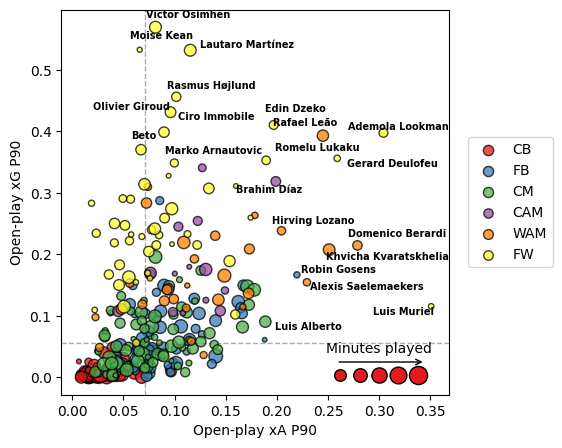

In [12]:
#selezione variabili
xvar = 'opxA_p90'
yvar = 'opxG_p90'

#definizione degli outlier da annotare con il nome
df['outlier_x'] = df[xvar] >= df[xvar].quantile(0.96)
df['outlier_y'] = df[yvar] >= df[yvar].quantile(0.96)
df['outlier'] = df.outlier_x | df.outlier_y

#definizione ruoli e colori
soccRoles = ['CB', 'FB', 'CM', 'CAM', 'WAM', 'FW']
palette = sns.color_palette('Set1', n_colors = len(soccRoles))

#rescaling dei minuti per la dimensione dei punti
scaler = MinMaxScaler((10,100))
df['marker_size'] = scaler.fit_transform(df.mins_played.values.reshape(-1,1)).flatten()

#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (5,5))

#scatter plot per ruolo con annotazione per outlier
annotations = []
for sr,color in zip(soccRoles,palette):
    dfsr = df[df.soccRole == sr]
    ax.scatter(dfsr[xvar], dfsr[yvar], color = color, s = dfsr.marker_size, label = sr, alpha = 0.75, edgecolor = 'black', zorder = 10)
    for i,r in dfsr[dfsr.outlier].iterrows():
        ann = ax.annotate(r.full_name, xy = (r[xvar], r[yvar]), fontsize = 7, weight = 'bold', ha = 'center', va = 'center', zorder = 11)
        annotations.append(ann)

#linee mediane
ax.axhline(df[yvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33, zorder = 1)
ax.axvline(df[xvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33, zorder = 1)

#riposizionamento automatico annotazioni evitando gli altri punti
adjust_text(annotations, df[xvar].values, df[yvar].values)

#legenda dimensione punti in base ai minuti
xstart = 0.72
ystart = 0.05
xstep = 0.05
xend = xstart+xstep*4
ystep = 0.035
for j in range(0,5):
    ax.scatter(xstart+xstep*j, ystart, c = palette[0], ec = 'black', s = 70+j*25, clip_on = False, transform = ax.transAxes)
ax.annotate("", xytext=(xstart-0.01, ystart+ystep), xy=(xend+0.02, ystart+ystep), xycoords = 'axes fraction', arrowprops=dict(arrowstyle="->", color = 'black'))
ax.annotate(f'Minutes played', ((xstart+xend)/2., ystart+2*ystep), xycoords = 'axes fraction', ha = 'center', va = 'center')

#label assi e legenda
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
leg = ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left', borderaxespad = 0)
plt.show()

In questo grafico vediamo la distribuzione dei giocatori per le due variabili, e abbiamo codificato due ulteriori informazioni: il ruolo tramite il colore, e i minuti giocati tramite la dimensione dei punti. Abbiamo anche tracciato le linee mediane delle nostre due variabili come riferimento, e annotato i nomi dei giocatori con valori più alti.

Ora vediamo come raggiungere questo risultato passo dopo passo. La componente principale è data dalla funzione `scatter` di Matplotlib.

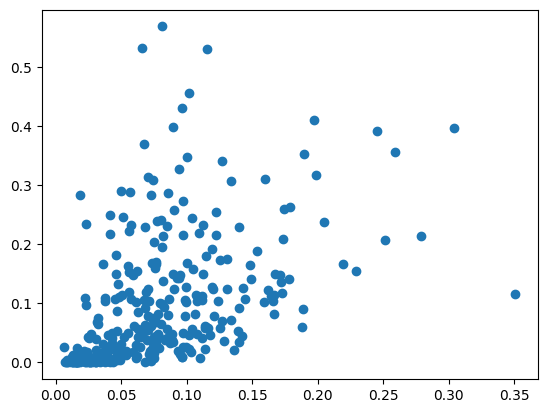

In [13]:
plt.scatter(df.opxA_p90, df.opxG_p90)

Questa funzione si può chiamare direttamente tramite PyPlot (importato come `plt`), ma è in generale buona pratica inizializzare una figura e un asse grafico in modo da avere maggiore controllo sui singoli elementi, utilizzando la funzione `subplots`. Possiamo per esempio impostare la dimensione della nostra figura in modo che sia quadrata, inserendo una tupla nel parametro `figsize`

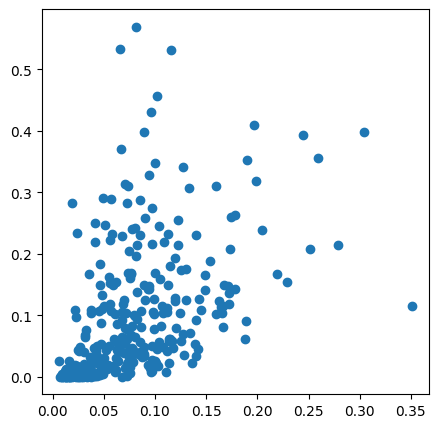

In [14]:
f, ax = plt.subplots(figsize = (5,5))
ax.scatter(df.opxA_p90, df.opxG_p90)
plt.show()

È sempre importante indicare chiaramente quali sono le variabili visualizzate, impostando i nomi degli assi tramite le funzioni `set_xlabel` e `set_ylabel`.

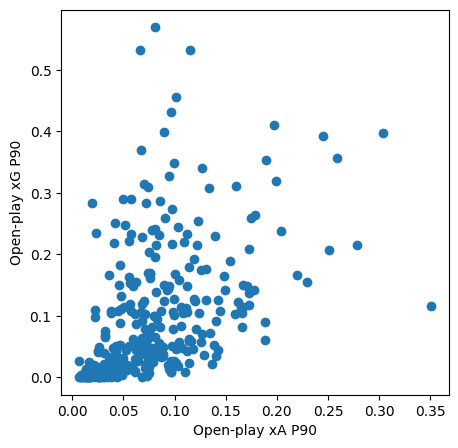

In [15]:
f, ax = plt.subplots(figsize = (5,5))
ax.scatter(df.opxA_p90, df.opxG_p90)
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
plt.show()

Se volessimo evidenziare diversi sottoinsiemi nei dati, per esempio dividendo i giocatori per ruolo, in questa implementazione dovremmo selezionare i diversi gruppi e ripetere il comando per ognuno tramite un ciclo `for`, assegnando a ogni gruppo un `label` che ci permetterà poi di creare una legenda. È anche utile inserire i nomi delle colonne che usiamo per le due variabili dentro degli oggetti specifici, in modo che se si volessero cambiare, il cambiamento non andrà ripetuto su tutto il codice, ma solo nella loro definizione.

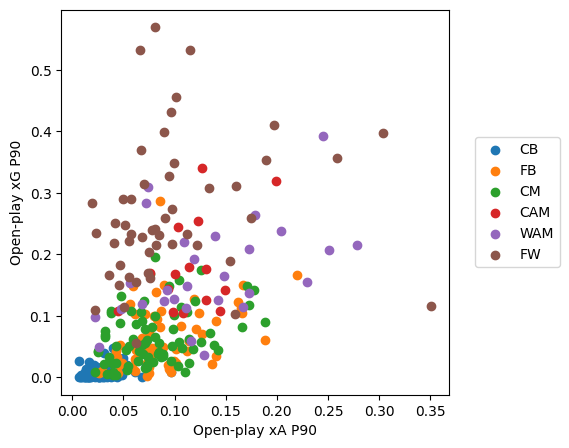

In [16]:
#selezione variabili
xvar = 'opxA_p90'
yvar = 'opxG_p90'

#definizione ruoli
soccRoles = ['CB', 'FB', 'CM', 'CAM', 'WAM', 'FW']

#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (5,5))

#scatter plot per ruolo
for sr in soccRoles:
    dfsr = df[df.soccRole == sr]
    ax.scatter(dfsr[xvar], dfsr[yvar], label = sr)

#label assi e legenda
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
leg = ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left')
plt.show()

Per aiutare a distinguere meglio i punti, possiamo tracciare un bordo nero per ognuno, e renderli leggermente trasparenti (tramite il parametro `alpha`) in modo da distinguere meglio punti sovrapposti. Possiamo inoltre tracciare delle linee in corrispondenza dei valori mediani delle due variabili per aiutare il lettore a orientarsi nel grafico, individuando velocemente valori maggior o minori del valore tipico.

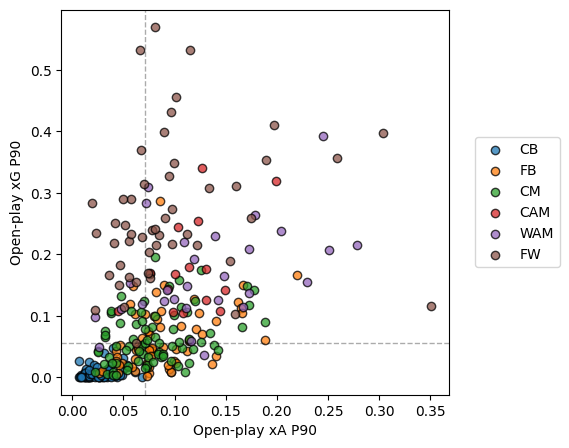

In [17]:
#definizione ruoli
soccRoles = ['CB', 'FB', 'CM', 'CAM', 'WAM', 'FW']

#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (5,5))

#scatter plot per ruolo
for sr in soccRoles:
    dfsr = df[df.soccRole == sr]
    ax.scatter(dfsr[xvar], dfsr[yvar], label = sr, edgecolors = 'black', alpha = 0.75)

#linee mediane
ax.axhline(df[yvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33)
ax.axvline(df[xvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33)

#label assi e legenda
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
leg = ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left')
plt.show()

A questo punto possiamo inserire un'ulteriore chiave di lettura utilizzando i minuti giocati. I valori numerici dei minuti sono troppo alti per essere usati direttamente per qui andranno riscalati in un range di valori tipici tramite la funzione `MinMaxScaler`.

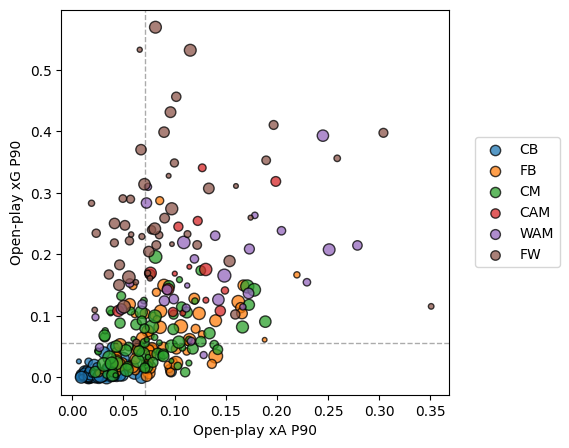

In [18]:
#definizione ruoli
soccRoles = ['CB', 'FB', 'CM', 'CAM', 'WAM', 'FW']

#rescaling dei minuti per la dimensione dei punti
scaler = MinMaxScaler((10,100))
df['marker_size'] = scaler.fit_transform(df.mins_played.values.reshape(-1,1)).flatten()

#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (5,5))

#scatter plot per ruolo
for sr in soccRoles:
    dfsr = df[df.soccRole == sr]
    ax.scatter(dfsr[xvar], dfsr[yvar], s = dfsr.marker_size, label = sr, edgecolors = 'black', alpha = 0.75)

#linee mediane
ax.axhline(df[yvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33)
ax.axvline(df[xvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33)

#label assi e legenda
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
leg = ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left')
plt.show()

In questo caso non abbiamo a dispozione una legenda automatizzata, ma possiamo andare a crearla manualmente disegnando dei punti che indichino come la dimensione aumenta con i minuti, andando a metterli nell'angolo in basso a destra, tracciandoli in coordinate di frazione degli assi tramite il parametro `transform`, e annotando anche una freccia usando il parametro `arrowprops` della funzione `annotate`. Per tenere il codice più ordinato possibile è bene definire delle variabili che contengono informazioni sulle coordinate dove vogliamo disporre questo elemento.

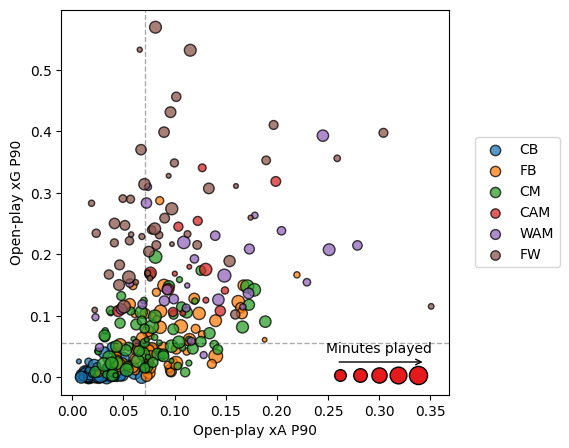

In [19]:
#definizione ruoli
soccRoles = ['CB', 'FB', 'CM', 'CAM', 'WAM', 'FW']

#rescaling dei minuti per la dimensione dei punti
scaler = MinMaxScaler((10,100))
df['marker_size'] = scaler.fit_transform(df.mins_played.values.reshape(-1,1)).flatten()

#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (5,5))

#scatter plot per ruolo
for sr in soccRoles:
    dfsr = df[df.soccRole == sr]
    ax.scatter(dfsr[xvar], dfsr[yvar], s = dfsr.marker_size, label = sr, edgecolors = 'black', alpha = 0.75)

#linee mediane
ax.axhline(df[yvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33)
ax.axvline(df[xvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33)

#legenda dimensione punti in base ai minuti
xstart = 0.72
ystart = 0.05
xstep = 0.05
xend = xstart+xstep*4
ystep = 0.035
for j in range(0,5):
    ax.scatter(xstart+xstep*j, ystart, c = palette[0], ec = 'black', s = 70+j*25, clip_on = False, transform = ax.transAxes)
ax.annotate("", xytext=(xstart-0.01, ystart+ystep), xy=(xend+0.02, ystart+ystep), xycoords = 'axes fraction', arrowprops=dict(arrowstyle="->", color = 'black'))
ax.annotate(f'Minutes played', ((xstart+xend)/2., ystart+2*ystep), xycoords = 'axes fraction', ha = 'center', va = 'center')

#label assi e legenda
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
leg = ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left')
plt.show()

Infine, possiamo annotare il nome dei giocatori che risaltano di più andando a individuare i punti con valori sopra un certo rank percentile, tramite la funzione `quantile` di Pandas. Per evitare di avere sovrapposizioni fra le varie annotazioni e anche con i punti stessi, possiamo usare la funzione `adjust_text`, parte di una libreria indipendente da Matplotlib. Infine, possiamo selezionare una scala di colori usando la funzione `color_palette` di Seaborn, invece che lasciare che Matplotlib selezioni i colori automaticamente.

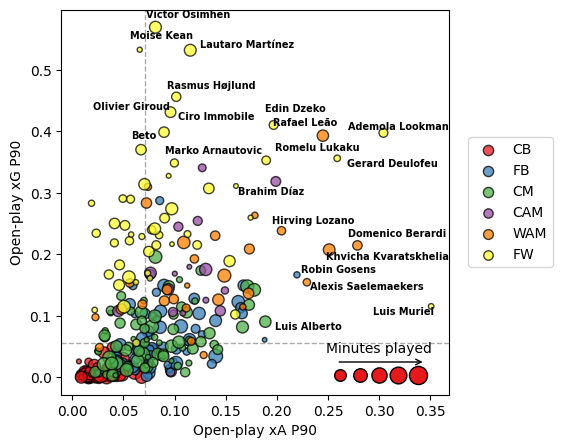

In [20]:
#selezione variabili
xvar = 'opxA_p90'
yvar = 'opxG_p90'

#definizione degli outlier da annotare con il nome
df['outlier_x'] = df[xvar] >= df[xvar].quantile(0.96)
df['outlier_y'] = df[yvar] >= df[yvar].quantile(0.96)
df['outlier'] = df.outlier_x | df.outlier_y

#definizione ruoli e colori
soccRoles = ['CB', 'FB', 'CM', 'CAM', 'WAM', 'FW']
palette = sns.color_palette('Set1', n_colors = len(soccRoles))

#rescaling dei minuti per la dimensione dei punti
scaler = MinMaxScaler((10,100))
df['marker_size'] = scaler.fit_transform(df.mins_played.values.reshape(-1,1)).flatten()

#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (5,5))

#scatter plot per ruolo con annotazione per outlier
annotations = []
for sr,color in zip(soccRoles,palette):
    dfsr = df[df.soccRole == sr]
    ax.scatter(dfsr[xvar], dfsr[yvar], color = color, s = dfsr.marker_size, label = sr, alpha = 0.75, edgecolor = 'black', zorder = 10)
    for i,r in dfsr[dfsr.outlier].iterrows():
        ann = ax.annotate(r.full_name, xy = (r[xvar], r[yvar]), fontsize = 7, weight = 'bold', ha = 'center', va = 'center', zorder = 11)
        annotations.append(ann)

#linee mediane
ax.axhline(df[yvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33, zorder = 1)
ax.axvline(df[xvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33, zorder = 1)

#riposizionamento automatico annotazioni evitando gli altri punti
adjust_text(annotations, df[xvar].values, df[yvar].values)

#legenda dimensione punti in base ai minuti
xstart = 0.72
ystart = 0.05
xstep = 0.05
xend = xstart+xstep*4
ystep = 0.035
for j in range(0,5):
    ax.scatter(xstart+xstep*j, ystart, c = palette[0], ec = 'black', s = 70+j*25, clip_on = False, transform = ax.transAxes)
ax.annotate("", xytext=(xstart-0.01, ystart+ystep), xy=(xend+0.02, ystart+ystep), xycoords = 'axes fraction', arrowprops=dict(arrowstyle="->", color = 'black'))
ax.annotate(f'Minutes played', ((xstart+xend)/2., ystart+2*ystep), xycoords = 'axes fraction', ha = 'center', va = 'center')

#label assi e legenda
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
leg = ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left', borderaxespad = 0)
plt.show()

È possibile scegliere i colori anche in modo manuale, scegliendo fra quelli riconosciuti da Matplotlib come stringa, oppure inserendo un codice esadecimale specifico. I colori riconsciuti tramite stringa sono i seguenti: https://matplotlib.org/3.5.0/_images/sphx_glr_named_colors_003.png

Un'opzione probabilmente più generalizzabile è utilizzare una scala di colori predefinita. Le scale disponibili in Matplotlib sono le seguenti: https://matplotlib.org/stable/gallery/color/colormap_reference.html

Le scale di colori *sequenziali* sono adatte a casi in cui si ha una variabile che aumenta in modo regolare da un valore minimo a uno massimo. Le scale *divergenti* sono adatte a variabili con due estremi ai lati e un valore neutro al centro, per esempio una variabile che va da $-X$ a $X$ passando per zero. Infine le scale *qualitative* sono indicate per casi come quello nel nostro esempio, dove stiamo usando il colore per codificare una variabile categorica con un numero non troppo alto di sottoinsiemi. Tutte queste scale di colori possono essere invertite semplicemente aggiungendo un `_r` al loro nome quando le inseriamo in un parametro. Nel nostro esempio abbiamo usato la scala qualitativa `Set1`.

Infine, vediamo come salvare le nostre figure tramite il comando `savefig`, che ci permette di indicare come stringa il nome del file, riconoscendo in modo automatico l'estensione (PNG, JPG, PDF, EPS etc.). Impostiamo anche il parametro `bbox_inches = 'tight'` per evitare dei bordi bianchi che verrebbero normalmente inseriti per default.

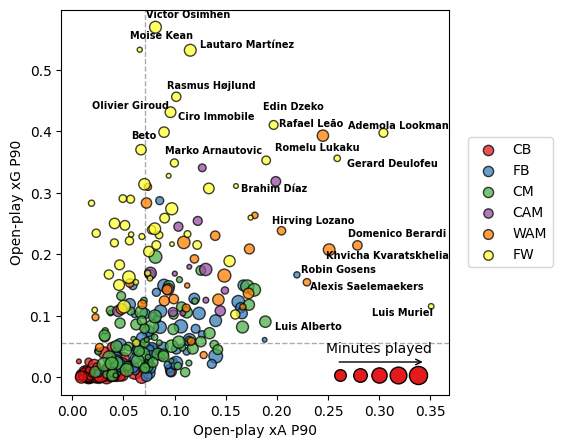

In [21]:
#selezione variabili
xvar = 'opxA_p90'
yvar = 'opxG_p90'

#definizione degli outlier da annotare con il nome
df['outlier_x'] = df[xvar] >= df[xvar].quantile(0.96)
df['outlier_y'] = df[yvar] >= df[yvar].quantile(0.96)
df['outlier'] = df.outlier_x | df.outlier_y

#definizione ruoli e colori
soccRoles = ['CB', 'FB', 'CM', 'CAM', 'WAM', 'FW']
palette = sns.color_palette('Set1', n_colors = len(soccRoles))

#rescaling dei minuti per la dimensione dei punti
scaler = MinMaxScaler((10,100))
df['marker_size'] = scaler.fit_transform(df.mins_played.values.reshape(-1,1)).flatten()

#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (5,5))

#scatter plot per ruolo con annotazione per outlier
annotations = []
for sr,color in zip(soccRoles,palette):
    dfsr = df[df.soccRole == sr]
    ax.scatter(dfsr[xvar], dfsr[yvar], color = color, s = dfsr.marker_size, label = sr, alpha = 0.75, edgecolor = 'black', zorder = 10)
    for i,r in dfsr[dfsr.outlier].iterrows():
        ann = ax.annotate(r.full_name, xy = (r[xvar], r[yvar]), fontsize = 7, weight = 'bold', ha = 'center', va = 'center', zorder = 11)
        annotations.append(ann)

#linee mediane
ax.axhline(df[yvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33, zorder = 1)
ax.axvline(df[xvar].median(), ls = '--', color = 'black', lw = 1, alpha = 0.33, zorder = 1)

#riposizionamento automatico annotazioni evitando gli altri punti
adjust_text(annotations, df[xvar].values, df[yvar].values)

#legenda dimensione punti in base ai minuti
xstart = 0.72
ystart = 0.05
xstep = 0.05
xend = xstart+xstep*4
ystep = 0.035
for j in range(0,5):
    ax.scatter(xstart+xstep*j, ystart, c = palette[0], ec = 'black', s = 70+j*25, clip_on = False, transform = ax.transAxes)
ax.annotate("", xytext=(xstart-0.01, ystart+ystep), xy=(xend+0.02, ystart+ystep), xycoords = 'axes fraction', arrowprops=dict(arrowstyle="->", color = 'black'))
ax.annotate(f'Minutes played', ((xstart+xend)/2., ystart+2*ystep), xycoords = 'axes fraction', ha = 'center', va = 'center')

#label assi e legenda
ax.set_xlabel('Open-play xA P90')
ax.set_ylabel('Open-play xG P90')
leg = ax.legend(bbox_to_anchor = (1.05,0.5), loc = 'center left', borderaxespad = 0)
# plt.show()
plt.savefig('scatter_example.png', bbox_inches = 'tight')

# Grafici a barre
I grafici a barre sono un altro tipo di visualizzazione dati molto comune e utilizzato, per esempio nella rappresentazione di classifiche. Vediamo un esempio usando i nostri dati sui passaggi chiave.

In un grafico di questo tipo non è molto sensato usare tutti i valori, ma di solito si scelgono per esempio i dieci con valore più alto. Dovremo quindi creare un altro dataframe dopo aver applicato `sort_values` in base alla variabile scelta.

In [22]:
dfb = df.sort_values('xT_from_passes_p90', ascending = False).head(10)

Vediamo come creare un semplice grafico a barre verticale con i primi 10 giocatori per passaggi chiave P90, usando una scala di colori per sottolineare il range di valori, e annotando il valore numerico sulle barre stesse. Dato che le barre si sviluppano sull'asse X, quello orizzontale, usiamo la funzione `barh`. In questo caso dovremo anche invertire l'asse Y per vedere i dati in ordine discendente, dato che normalmente il grafico partirebbe dal basso verso l'alto.

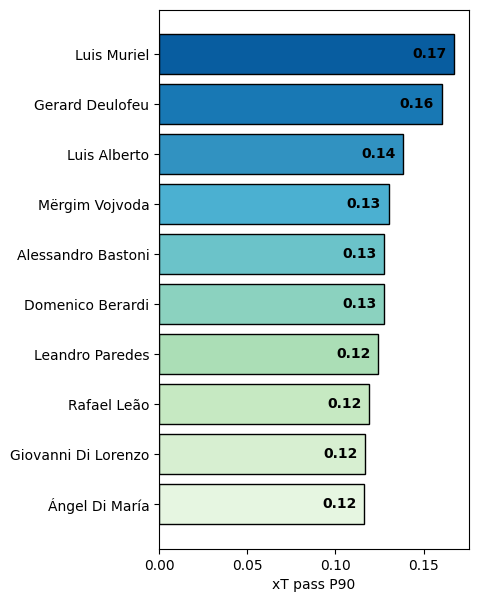

In [23]:
#inizializzazione figura e asse
f, ax = plt.subplots(figsize = (4,7))

#creazione barre orizzontali: nome full_name su y, passaggi chiave p90 su x, scala di colore verde-blu
bars = ax.barh(y = dfb.full_name, width = dfb['xT_from_passes_p90'], color = sns.color_palette('GnBu_r', n_colors = 10), ec = 'black')

#annotazione valori sopra le barre
ax.bar_label(bars, fmt = '%.2f', padding = -30, weight = 'bold')

#label assi
ax.set_xlabel('xT pass P90')

#inversione asse Y per ordine discendente
ax.invert_yaxis()
plt.show()

Lo stesso tipo di grafico si può realizzare anche in orizzontale, con la funzione `bar`. In questo caso non abbiamo bisogno di invertire l'asse, ma dovremo solo cambiare alcuni degli input. Inoltre è necessario applicare una rotazione ai ticklabels dell'asse X tramite la funzione `set_xticklabels`, impostando il parametro `rotation`.

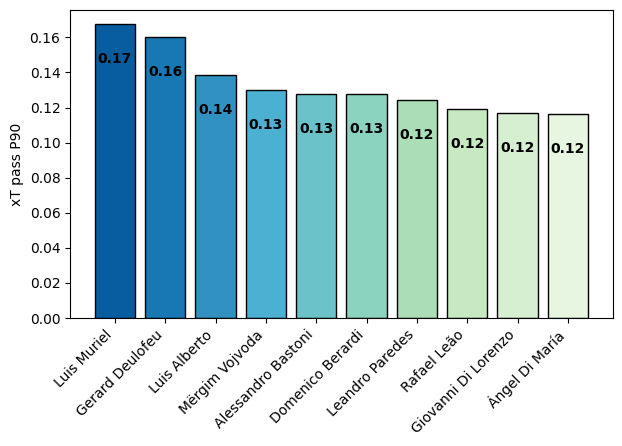

In [24]:
#inizializzazione figura e asse (invertiamo le dimensioni rispetto al grafico precedente)
f, ax = plt.subplots(figsize = (7,4))

#creazione barre orizzontali: nome full_name su x, passaggi chiave p90 su y, scala di colore verde-blu
bars = ax.bar(x = dfb.full_name, height = dfb['xT_from_passes_p90'], color = sns.color_palette('GnBu_r', n_colors = 10), ec = 'black')

#annotazione valori sopra le barre
ax.bar_label(bars, fmt = '%.2f', padding = -30, weight = 'bold')

#label assi
ax.set_ylabel('xT pass P90')

#applica rotazione ticklabels X
ax.set_xticklabels(dfb.full_name, rotation = 45, ha = 'right')

plt.show()

È possibile anche visualizzare un ranking in base a una metrica combinata, mostrando le diverse componenti sottostanti, tramite un grafico a barre cumulativo. Vediamo un esempio usando npxG + opxA. Definiamo prima una variabile somma ed estraiamo un dataframe con i primi 10 giocatori.

In [25]:
df['npxG_opxA_p90'] = df[['npxG_p90', 'opxA_p90']].sum(axis = 1)

dftop = df.sort_values('npxG_opxA_p90', ascending = False).head(10).reset_index()

Andiamo ora a creare il grafico, tracciando prima un grafico a barre per npxG P90, e poi uno per opxA P90 sullo stesso asse, imponendo tramite il parametro `left` che le barre partano dal valore di npxG P90 di ogni giocatore, per ottenere delle barre cumulative.

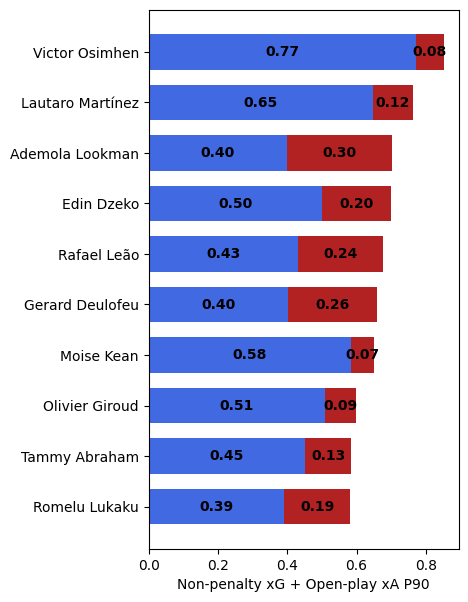

In [27]:
f, ax = plt.subplots(figsize = (4,7))

bars = ax.barh(dftop.index, dftop.npxG_p90, height=0.7, color='royalblue')
barLabs = ax.bar_label(bars, fmt = '%.2f', label_type = 'center', color = 'black', weight = 'bold')

bars2 = ax.barh(dftop.index, dftop.opxA_p90, height=0.7, left = dftop.npxG_p90, color='firebrick')
barLabs2 = ax.bar_label(bars2, fmt = '%.2f', label_type = 'center', color = 'black', weight = 'bold')

ax.set_yticks(dftop.index, labels = dftop.full_name)
ax.set_xlabel('Non-penalty xG + Open-play xA P90')
ax.invert_yaxis()
plt.show()

Ovviamente questo metodo si può generalizzare a più di due metriche, anche se il grafico diventerà difficile da leggere se diventano troppe. Per evitare di ripetere codice, possiamo usare un ciclo `for`. Per facilitare la lettura, possiamo annotare un titolo che includa una legenda del colore delle barre, usando il pacchetto `highlight_text`. Possiamo anche rimuovere le annotazioni per i segmenti di barra con meno di 0.1, per evitare di avere annotazioni più grandi del segmento stesso.

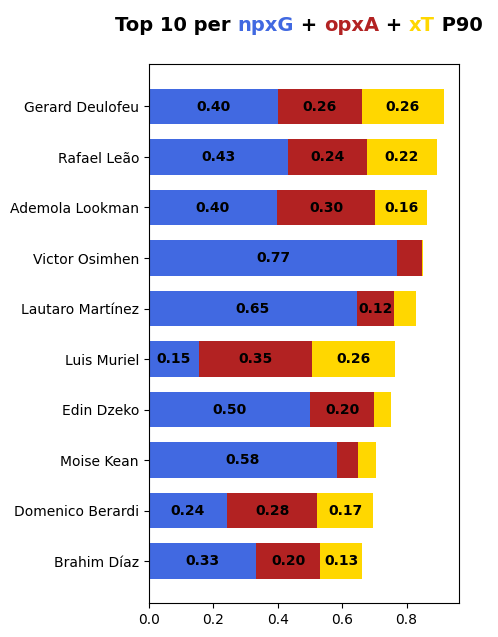

In [29]:

var1 = 'npxG_p90'
var2 = 'opxA_p90'
var3 = 'xT_p90'

df['npxG_opxA_xT_p90'] = df[['npxG_p90', 'opxA_p90', 'xT_p90']].sum(axis = 1)
dftop = df.sort_values('npxG_opxA_xT_p90', ascending = False).head(10).reset_index()
data = dftop[[var1, var2, var3]].values
data_cum = data.cumsum(axis=1)

category_colors = ['royalblue', 'firebrick', 'gold']

f, ax = plt.subplots(figsize = (4,7))

labs = []
for i,color in enumerate(category_colors):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    bars = ax.barh(dftop.index, widths, left = starts, height=0.7, color=color)
    barLabs = ax.bar_label(bars, fmt = '%.2f', label_type = 'center', color = 'black', weight = 'bold')
    labs.append(barLabs)

#remove labels if less than 0.1
for lab in labs:
    for l in lab:
        if float(l.get_text()) < 0.1:
            l.set_text('')

ax.set_yticks(dftop.index, labels = dftop.full_name)

fig_text(
    0.5, 0.95, "Top 10 per <npxG> + <opxA> + <xT> P90", fig=f, size = 14,
    highlight_textprops=[{"color": 'royalblue'}, {"color": 'firebrick'}, {"color": 'gold'}],
    ha="center", weight = 'extra bold'
)

ax.invert_yaxis()
plt.show()

# Pizza charts

Vediamo come usare delle variabili riscalate usando metodi visti in precedenza come il ranking percentile, per visualizzare nello stesso grafico il livello di un giocatore in base a diverse metriche con valori assoluti molto diversi. Scegliamo come esempio 10 metriche, fra quelle avanzate, tattiche e fisiche a nostra disposizione, e calcoliamo per ciascuna una nuova colonna con il ranking percentile del suo valore normalizzato.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 19620 to 559928
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   full_name                    312 non-null    object 
 1   birth_date                   312 non-null    object 
 2   country                      312 non-null    object 
 3   soccRole                     312 non-null    object 
 4   team                         312 non-null    object 
 5   cluster                      312 non-null    int64  
 6   games                        312 non-null    int64  
 7   mins_played                  312 non-null    int64  
 8   touches                      312 non-null    int64  
 9   xG                           312 non-null    float64
 10  npxG                         312 non-null    float64
 11  opxG                         312 non-null    float64
 12  goals                        312 non-null    int64  
 13  npgoals           

In [31]:
df['npxG_per_shot'] = df.npxG / df.npshots
df['goals_per_xG'] = df.npgoals / df.npxG
df['sga'] = df.xGoT - df.xG

df = df.fillna(0)

In [32]:
metriche = ['npxG_p90', 'npxG_per_shot', 'goals_per_xG', 'sga', 'opxA_p90', 'xOVA_p90', 'xT_from_passes_p90', 'xT_from_carries_p90']
metriche_rank = [f'{m}_rank' for m in metriche]

df[metriche_rank] = (100 * df[metriche].rank(pct = True)).astype(int)

Ora che abbiamo le nostre metriche in forma di ranking percentile, possiamo usare la funzione `PyPizza` della libreria MplSoccer per creare un semplice pizza chart. Questa libreria utilizza sempre Matplotlib dietro le quinte, ma fornisce uno strumento più immediato per realizzare il grafico senza dover scrivere il codice da zero. Vediamo un esempio con i dati di Kvaratskhelia, identificato con il `opta_id = 440668`. In questo momento non focalizziamoci sui dettagli del codice, l'idea è di introdurre uno strumento che poi avrete modo di approfondire per conto vostro consultando la documentazione della libreria, che trovate qui:
https://mplsoccer.readthedocs.io/en/latest/gallery/index.html#pizza-plots

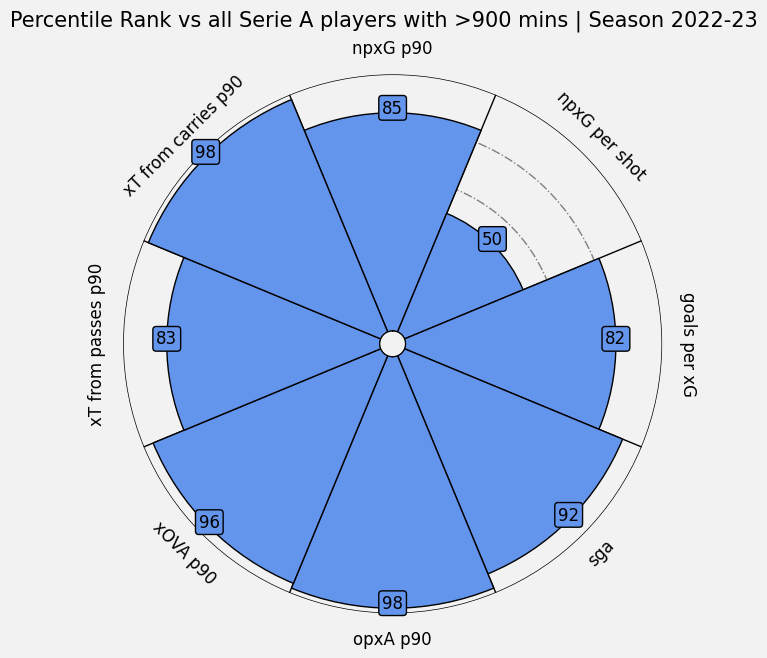

In [34]:
# parameter list

# values for corresponding parameters
values = df.loc[440668, metriche_rank].values


# instantiate PyPizza class
baker = PyPizza(
    params=[x.replace('_', ' ') for x in metriche],                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

# plot pizza
fig, ax = baker.make_pizza(
    values,              # list of values
    figsize=(7,7),      # adjust figsize according to your need
    param_location=110,  # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add subtitle
fig.text(
    0.5, 0.95,
    "Percentile Rank vs all Serie A players with >900 mins | Season 2022-23",
    size=15,
    ha="center")

plt.show()

Vediamo anche un esempio di confronto fra i valori di due giocatori: inseriamo un secondo array di valori sotto il parametro `compare_values`, usando un altro colore, che riprendiamo poi nel titolo usando i colori corrispondenti tramite il pacchetto `highlight_text`.

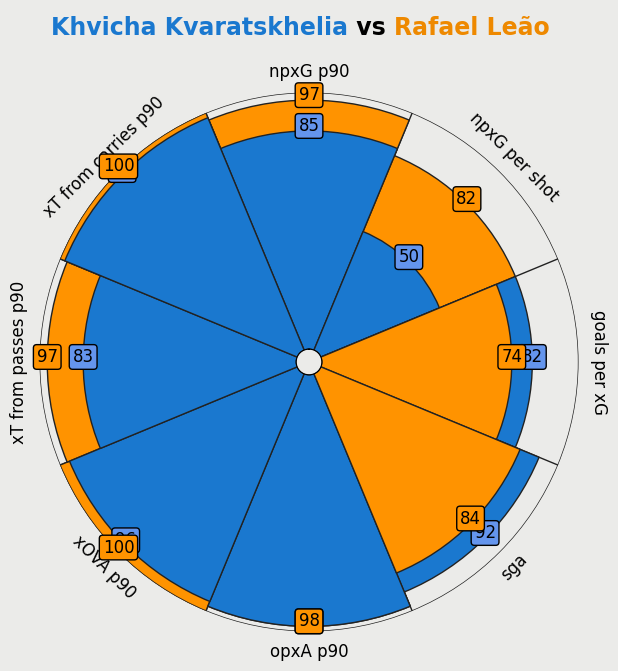

In [35]:
# parameter list

values = df.loc[440668, metriche_rank].values    # for Kvaratskhelia
values_2 = df.loc[216065, metriche_rank].values  # for Leao

# instantiate PyPizza class
baker = PyPizza(
    params=[x.replace('_', ' ') for x in metriche],                  # list of parameters
    background_color="#EBEBE9",     # background color
    straight_line_color="#222222",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    last_circle_color="#222222",    # color of last circle
    other_circle_ls="-.",           # linestyle for other circles
    other_circle_lw=1               # linewidth for other circles
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                     # list of values
    compare_values=values_2,    # comparison values
    figsize=(7,7),             # adjust figsize according to your need
    kwargs_slices=dict(
        facecolor="#1A78CF", edgecolor="#222222",
        zorder=2, linewidth=1
    ),                          # values to be used when plotting slices
    kwargs_compare=dict(
        facecolor="#FF9300", edgecolor="#222222",
        zorder=2, linewidth=1,
    ),
    kwargs_params=dict(
        color="#000000", fontsize=12, va="center"
    ),                          # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    ),                          # values to be used when adding parameter-values labels
    kwargs_compare_values=dict(
        color="#000000", fontsize=12, zorder=3,
        bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
    ),                          # values to be used when adding parameter-values labels
)

# add title
fig_text(
    0.5, 0.99, "<Khvicha Kvaratskhelia> vs <Rafael Leão>", size=17, fig=fig,
    highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
    ha="center", color="#000000", weight = 'extra bold'
)
plt.show()